In [1]:
from utils import *
from normalizers import *
from FLPO import *
from viz import *
from UAV_Net import UAV_Net
from annealing import anneal
import pickle

In [ ]:
import random
import numpy as np

# fix all the seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
drones = [
    ((10.0, 5.0), (45.0, 50.0), 1.0),  # Long distance, high charge
    ((3.0, 40.0), (50.0, 10.0), 1.0),  # Long distance, medium charge
    ((20.0, 15.0), (35.0, 35.0), 1.0),  # Moderate distance, medium charge
    ((5.0, 30.0), (25.0, 5.0), 1.0),  # Moderate distance, low charge
    ((40.0, 45.0), (10.0, 10.0), 1.0),  # Long distance, high charge
    ((30.0, 20.0), (5.0, 35.0), 1.0),  # Moderate distance, medium charge
    ((15.0, 10.0), (40.0, 40.0), 1.0),  # Moderate distance, low charge
    ((35.0, 5.0), (10.0, 45.0), 1.0),  # Long distance, medium charge
    ((25.0, 40.0), (20.0, 10.0), 1.0),  # Moderate distance, high charge
    ((45.0, 15.0), (5.0, 20.0), 1.0),  # Long distance, low charge
]
N_stations = 5
init_ugv = np.repeat(
    np.array(
        [
            [0.5, 0.9],
        ]
    ),
    N_stations,
    axis=0,
)
fcr = 15.0  # Full Charge Range
ugv_factor = 0.0  # the cost factor for UGV transportation
distance = "euclidean"  # distance measure in the environment
blocks = None # for benchmark we ignore blocks
n_algo_iters = 1

# FLPO Algorithm

In [3]:
beta_init = 1e-4  # initial beta value for the optimization.
beta_f = 1e4  # final beta value for the optimization
alpha = 2.0  # beta growth rate
purturb = 1e-6  # random purturbation in optimization

uav_net = UAV_Net(drones, N_stations, init_ugv, blocks, ugv_factor, fcr, distance)
obj = uav_net.objective
Y_s, Betas = anneal(
    obj,
    uav_net.stations,
    uav_net.bounds,
    beta_init,
    beta_f,
    alpha,
    purturb,
    "powell",
    True,
)

UAV Network was successfully created.
Beta: 1.00e-04  F.E.: -7.43145e+05
Beta: 2.00e-04  F.E.: -3.71060e+05
Beta: 4.00e-04  F.E.: -1.85014e+05
Beta: 8.00e-04  F.E.: -9.19907e+04
Beta: 1.60e-03  F.E.: -4.54799e+04
Beta: 3.20e-03  F.E.: -2.22257e+04
Beta: 6.40e-03  F.E.: -1.06013e+04
Beta: 1.28e-02  F.E.: -4.80580e+03
Beta: 2.56e-02  F.E.: -1.99395e+03
Beta: 5.12e-02  F.E.: -6.82847e+02
Beta: 1.02e-01  F.E.: -2.26923e+02
Beta: 2.05e-01  F.E.: -5.55349e+01
Beta: 4.10e-01  F.E.: 8.26252e+01
Beta: 8.19e-01  F.E.: 7.74309e+01
Beta: 1.64e+00  F.E.: 1.57200e+02
Beta: 3.28e+00  F.E.: 1.83668e+02
Beta: 6.55e+00  F.E.: 1.89775e+02
Beta: 1.31e+01  F.E.: 9.43154e+00
Beta: 2.62e+01  F.E.: 9.47222e+00
Beta: 5.24e+01  F.E.: 9.49876e+00
Beta: 1.05e+02  F.E.: 9.49853e+00
--Optimization Terminated--
Elapsed time: 11.35




Drone 1 --->f2 --->f1 --->f3 --->[D1]
Drone 2 --->f4 --->f1 --->f5 --->[D2]
Drone 3 --->f2 --->f1 --->[D3]
Drone 4 --->f4 --->f1 --->f2 --->[D4]
Drone 5 --->f3 --->f1 --->f2 --->[D5]
Drone 6 --->f1 --->f4 --->[D6]
Drone 7 --->f2 --->f1 --->f3 --->[D7]
Drone 8 --->f5 --->f1 --->f4 --->[D8]
Drone 9 --->f1 --->f2 --->[D9]
Drone 10 --->f5 --->f1 --->f4 --->[D10]

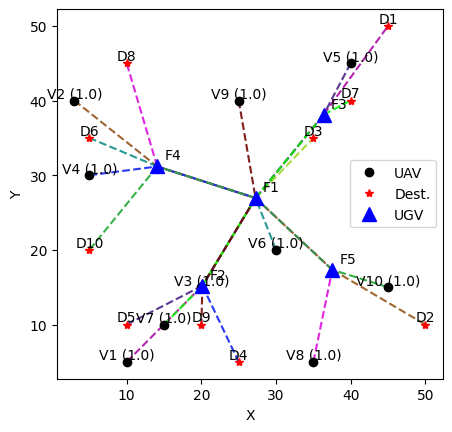

In [4]:
from matplotlib import pyplot as plt
uav_net.return_stagewise_cost(Y_s[-1], Betas[-1])
P_ss = calc_associations(uav_net.D_ss, Betas[-1])
routes = calc_routs(P_ss)
print_routs(routes, N_stations)
scale = uav_net.ub - uav_net.lb
drift = uav_net.lb
f_s = Y_s[-1] * scale + drift
plot_drone_routes(
    drones, f_s, blocks, routes, fcr, ugv_factor, ugv_init_loc=None, save_=False
)

In [5]:
uav_net.return_total_cost()

446.42405285538

# GUROBI

In [5]:
s = np.array([ [list(start)] for start, _, _ in drones ]) / 47.0
e = np.array([ [list(end)] for _, end, _ in drones ]) / 47.0
num_nodes = N_stations
num_agents = len(drones)
T = num_nodes + 1
dim_ = 2
F_base = init_ugv.copy()
threshold = fcr / 47.0


In [7]:
from GurobiSolver import SolveMIP

gap = 0.0
best_y, best_eta, cost, elapsed_time = SolveMIP(
    s,
    e,
    num_agents,
    num_nodes,
    T,
    dim_,
    threshold=threshold,
    y_init=None,
    gap=gap,
)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-07-28
Read LP format model from file C:\Users\salar\AppData\Local\Temp\tmpl_ch125e.pyomo.lp
Reading time = 0.00 seconds
x1: 228 rows, 550 columns, 844 nonzeros
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 228 rows, 550 columns and 844 nonzeros
Model fingerprint: 0x0f1ab7e6
Model has 180 quadratic constraints
Variable types: 190 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e-01, 1e+00]
  Objective range  [1e-01, 1e-01]
  Bounds range     [5e-02, 1e+00]
  RHS range        [3e-01, 1e+00]
  QRHS range       [6e-02, 1e+0

In [8]:
cost * 47 * num_agents

434.08870608929124

In [9]:
elapsed_time

37.53169560432434

# GA

In [15]:
from GA import ga, ga_plot, ga_print

t_ga_arr = []
c_ga_arr = []
for i in range(n_algo_iters):
    best_y, best_eta, best_cost, elapsed_time = ga(
        s,
        e,
        num_nodes,
        num_agents,
        dim_,
        threshold=threshold,
        Y_init=None,
        verbose=True,
        pop_size=100,
        generations=15000,
        mutation_rate=0.3,
    )
    t_ga_arr.append(elapsed_time)
    c_ga_arr.append(best_cost)
t_ga_min = np.min(t_ga_arr)
c_ga_min = np.min(c_ga_arr)

Generation 1/15000, Best Cost: 1604.1453
Generation 51/15000, Best Cost: 581.8136
Generation 101/15000, Best Cost: 580.0218
Generation 151/15000, Best Cost: 547.8210
Generation 201/15000, Best Cost: 542.2449
Generation 251/15000, Best Cost: 542.2449
Generation 301/15000, Best Cost: 531.1973
Generation 351/15000, Best Cost: 511.6782
Generation 401/15000, Best Cost: 511.6782
Generation 451/15000, Best Cost: 445.3400
Generation 501/15000, Best Cost: 445.3400
Generation 551/15000, Best Cost: 445.3400
Generation 601/15000, Best Cost: 445.3400
Generation 651/15000, Best Cost: 434.0559
Generation 701/15000, Best Cost: 434.0559
Generation 751/15000, Best Cost: 434.0559
Generation 801/15000, Best Cost: 395.4792
Generation 851/15000, Best Cost: 317.7775
Generation 901/15000, Best Cost: 313.1895
Generation 951/15000, Best Cost: 313.1895
Generation 1001/15000, Best Cost: 313.1895
Generation 1051/15000, Best Cost: 313.1895
Generation 1101/15000, Best Cost: 313.1895
Generation 1151/15000, Best Cost:

# SA

In [32]:
from SA import sa, plot_sa, print_sa
t_sa_arr = []
c_sa_arr = []

for i in range(n_algo_iters):
    best_y, best_eta, best_cost, elapsed_time = sa(
            s,
            e,
            num_nodes,
            num_agents,
            dim_,
            threshold=threshold,
            Y_init=None,
            YMIN=0,
            YMAX=1.0,
            T_start=10,
            iters=50000,
            verbose=True,
        )
    t_sa_arr.append(elapsed_time)
    c_sa_arr.append(best_cost)
t_sa_min = np.min(t_sa_arr)
c_sa_min = np.min(c_sa_arr)
# print_sa(s, e, best_y, best_eta)
# plot_sa(s, e, best_y, best_eta)

Iteration 1/50000, Best Cost: 3113.1211, Temperature: 9.9500
Iteration 5001/50000, Best Cost: 592.2765, Temperature: 0.0000
Iteration 10001/50000, Best Cost: 570.9977, Temperature: 0.0000
Iteration 15001/50000, Best Cost: 505.1868, Temperature: 0.0000
Iteration 20001/50000, Best Cost: 505.1868, Temperature: 0.0000
Iteration 25001/50000, Best Cost: 505.1868, Temperature: 0.0000
Iteration 30001/50000, Best Cost: 505.1868, Temperature: 0.0000
Iteration 35001/50000, Best Cost: 473.0250, Temperature: 0.0000
Iteration 40001/50000, Best Cost: 402.7538, Temperature: 0.0000
Iteration 45001/50000, Best Cost: 402.7538, Temperature: 0.0000
Iteration 50000/50000, Best Cost: 402.7538, Temperature: 0.0000
Elapsed time: 32.11 seconds Best Cost: 402.7538


# CEM

In [38]:
from CEM import cem, plot_cem, print_cem

t_cem_arr = []
c_cem_arr = []
for i in range(n_algo_iters):
    best_y, best_eta, best_cost, elapsed_time = cem(
            s,
            e,
            num_nodes,
            num_agents,
            dim_,
            threshold=threshold,
            Y_init=None,
            YMIN=0,
            YMAX=1.0,
            n_iter=2000,
            pop_size=200,
            elite_frac=0.1,
            verbose=True,
        )
    t_cem_arr.append(elapsed_time)
    c_cem_arr.append(best_cost)
t_cem_min = np.min(t_cem_arr)
c_cem_min = np.min(c_cem_arr)

Iteration 1/2000, Best Cost: 2285.7468
Iteration 201/2000, Best Cost: 661.2421
Iteration 401/2000, Best Cost: 660.0989
Iteration 601/2000, Best Cost: 659.5528


KeyboardInterrupt: 

# PSO

Iter   0 | Best Cost: 855.1182 | Mean Cost: 1917.3241
Iter 100 | Best Cost: 452.3527 | Mean Cost: 712.6764
Iter 200 | Best Cost: 360.0104 | Mean Cost: 513.3499
Iter 299 | Best Cost: 300.7673 | Mean Cost: 384.6213
=== PSO Results ===
Best Cost: 300.7673
Elapsed Time: 81.9177 seconds
Node positions (y):
[[0.66599023 0.57938309]
 [0.32419924 0.53295684]
 [0.48168808 0.31291166]
 [0.35486078 0.69391415]
 [0.61741617 0.69394837]]
Agent paths (eta):
[[2 2 0 0 0 5]
 [3 0 3 0 0 5]
 [1 3 1 3 4 5]
 [3 1 2 0 2 5]
 [4 0 3 1 1 5]
 [4 1 5 1 1 5]
 [1 1 3 4 0 5]
 [2 0 4 0 3 5]
 [3 3 1 1 1 5]
 [0 0 2 1 1 5]]
Agent 0 path:
Node 2 -> Node 2 -> Node 0 -> Node 0 -> Node 0 -> End
Agent 1 path:
Node 3 -> Node 0 -> Node 3 -> Node 0 -> Node 0 -> End
Agent 2 path:
Node 1 -> Node 3 -> Node 1 -> Node 3 -> Node 4 -> End
Agent 3 path:
Node 3 -> Node 1 -> Node 2 -> Node 0 -> Node 2 -> End
Agent 4 path:
Node 4 -> Node 0 -> Node 3 -> Node 1 -> Node 1 -> End
Agent 5 path:
Node 4 -> Node 1 -> End -> Node 1 -> Node 1 -> 

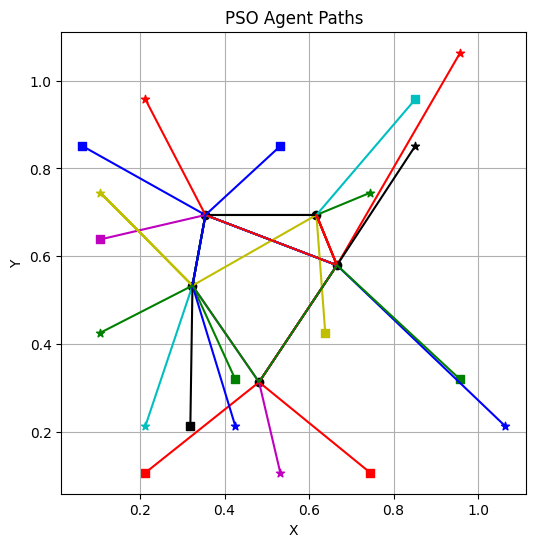

In [ ]:
from PSO import pso, pso_plot, pso_print

num_particles = 500
num_iters = 2000
w = 0.9 # inertia weight
c1 = 0.5  # cognitive (individual) weight
c2 =1.5  # social (group) weight
t_pso_arr = []
c_pso_arr = []
for i in range(n_algo_iters):
    y_final, eta_final, global_best_cost, elapsed_time = pso(
        s,
        e,
        num_nodes,
        num_agents,
        dim_,
        threshold= threshold,
        Y_init=None,
        verbose=True,
        w=w,
        c1=c1,
        c2=c2,
        num_particles=num_particles,
        num_iters=num_iters,
    )
    t_pso_arr.append(elapsed_time)
    c_pso_arr.append(global_best_cost)

t_pso_min = np.min(t_pso_arr)
c_pso_min = np.min(c_pso_arr)


In [ ]:
import pickle

benchmark_data = {
    "s":s, 
    "e":e,
    "n_algo_iters":n_algo_iters,
    "t_pso_arr":t_pso_arr,
    "c_pso_arr":c_pso_arr,
    "t_ga_arr":t_ga_arr,
    "c_ga_arr":c_ga_arr,
    "t_sa_arr":t_sa_arr,
    "c_sa_arr":c_sa_arr,
    "t_cem_arr":t_cem_arr,
    "c_cem_arr":c_cem_arr,
    "t_flpoANN_arr":t_flpo_arr,
    "c_flpoANN_arr":c_flpo_arr
}

scenario = f"N{int(num_agents)}_M{int(num_nodes)}_seed{int(seed)}"
filepath = "benchmark_data/" + scenario
print(filepath)

with open(filepath, 'wb') as file:
    pickle.dump(benchmark_data, file)

In [ ]:
# extract min, mean, and std for each algorithm (cost and time)
def extract_stats(arr):
    if arr is None:
        return None, None, None
    return np.min(arr), np.mean(arr), np.std(arr)
t_pso_min, t_pso_mean, t_pso_std = extract_stats(t_pso_arr)
c_pso_min, c_pso_mean, c_pso_std = extract_stats(c_pso_arr)
t_ga_min, t_ga_mean, t_ga_std = extract_stats(t_ga_arr)
c_ga_min, c_ga_mean, c_ga_std = extract_stats(c_ga_arr)
t_sa_min, t_sa_mean, t_sa_std = extract_stats(t_sa_arr)
c_sa_min, c_sa_mean, c_sa_std = extract_stats(c_sa_arr)
t_cem_min, t_cem_mean, t_cem_std = extract_stats(t_cem_arr)
c_cem_min, c_cem_mean, c_cem_std = extract_stats(c_cem_arr)
t_flpoANN_min, t_flpoANN_mean, t_flpoANN_std = extract_stats(t_flpo_arr)
c_flpoANN_min, c_flpoANN_mean, c_flpoANN_std = extract_stats(c_flpo_arr)
# print the results
# print(f"PSO: time (min, mean, std) = ({t_pso_min:.5f}, {t_pso_mean:.5f}, {t_pso_std:.5f}), cost (min, mean, std) = ({c_pso_min:.5f}, {c_pso_mean:.5f}, {c_pso_std:.5f})")
print(f"GA: time (min, mean, std) = ({t_ga_min:.5f}, {t_ga_mean:.5f}, {t_ga_std:.5f}), cost (min, mean, std) = ({c_ga_min:.5f}, {c_ga_mean:.5f}, {c_ga_std:.5f})")
print(f"SA: time (min, mean, std) = ({t_sa_min:.5f}, {t_sa_mean:.5f}, {t_sa_std:.5f}), cost (min, mean, std) = ({c_sa_min:.5f}, {c_sa_mean:.5f}, {c_sa_std:.5f})")
print(f"CEM: time (min, mean, std) = ({t_cem_min:.5f}, {t_cem_mean:.5f}, {t_cem_std:.5f}), cost (min, mean, std) = ({c_cem_min:.5f}, {c_cem_mean:.5f}, {c_cem_std:.5f})")
# print(f"ACO: time (min, mean, std) = ({t_aco_min:.5f}, {t_aco_mean:.5f}, {t_aco_std:.5f}), cost (min, mean, std) = ({c_aco_min:.5f}, {c_aco_mean:.5f}, {c_aco_std:.5f})")
print(f"FLPO-ANN: time (min, mean, std) = ({t_flpoANN_min:.5f}, {t_flpoANN_mean:.5f}, {t_flpoANN_std:.5f}), cost (min, mean, std) = ({c_flpoANN_min:.5f}, {c_flpoANN_mean:.5f}, {c_flpoANN_std:.5f})")
